In [1]:
import torch
import torchvision
import numpy as np
import torch.multiprocessing as mp
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import os
import copy
import warnings
import time
#importing custom py file with functions and the CLPSO algorithm
try:
    import CLPSO_GRAD_script
except Exception as e:
    print("Failed to import script:", e)
os.environ['PYTHONWARNINGS'] = 'ignore::UserWarning:torchvision.io.image'


/school/GPTEngineer_conda/Miniconda3/envs/CNN/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/school/GPTEngineer_conda/Miniconda3/envs/CNN/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
#Setting CUDA and multiprocessing
mp.set_start_method('spawn', force=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define and load model
model = CLPSO_GRAD_script.my_CNN()
PATH = '/school/intelligence_coursework/new_CNN/trained_network/new_CNN_notebook.pth'
model.load_state_dict(torch.load(PATH, map_location=device))

#Using GPU
model = model.to(device)
print("Model device:", next(model.parameters()).device)

Model device: cuda:0


In [3]:
# Load and preprocess CIFAR-10 data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#augmented images for trainset
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=augmented_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)

classes = trainset.classes
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trained_model, epoch_losses, epoch_precisions = CLPSO_GRAD_script.run_clpso(PATH, testloader, criterion, fine_tune_epochs=10, num_particles=10)

Epoch 1/10
Particle 1 evaluated. Fitness: 4.8130
Particle 2 evaluated. Fitness: 4.6926
Particle 3 evaluated. Fitness: 4.2169
Particle 4 evaluated. Fitness: 4.7317
Particle 5 evaluated. Fitness: 4.4555
Particle 6 evaluated. Fitness: 4.3289
Particle 7 evaluated. Fitness: 4.1340
Particle 8 evaluated. Fitness: 6.0035
Particle 9 evaluated. Fitness: 4.0041
Particle 10 evaluated. Fitness: 4.5447
New global best fitness: 4.8130
New global best fitness: 4.6926
New global best fitness: 4.2169
New global best fitness: 4.1340
New global best fitness: 4.0041
Epoch 1/10 - Validation Loss: 1.9258, Precision: 0.6282
Epoch 1/10 - Best Global Fitness: 4.0041
Epoch 2/10
Particle 1 evaluated. Fitness: 2.7638
Particle 2 evaluated. Fitness: 2.8655
Particle 3 evaluated. Fitness: 2.4696
Particle 4 evaluated. Fitness: 2.7587
Particle 5 evaluated. Fitness: 2.5828
Particle 6 evaluated. Fitness: 2.6064
Particle 7 evaluated. Fitness: 2.5418
Particle 8 evaluated. Fitness: 3.1989
Particle 9 evaluated. Fitness: 2.583

In [9]:
#Evaluation mode
trained_model.eval()

#Initialize evaluation metrics
correct = 0
total = 0
class_correct = {classname: 0 for classname in classes}
class_total = {classname: 0 for classname in classes}

#Accuracy on the whole test set
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels, predicted):
            if label == prediction:
                class_correct[classes[label.item()]] += 1
            class_total[classes[label.item()]] += 1

print('Accuracy of the network on the test images: %f %%' % (100 * correct / total))

#Accuracy for each class
for classname, correct_count in class_correct.items():
    accuracy = 100 * float(correct_count) / class_total[classname]
    print(f'Accuracy for class {classname:5s} is {accuracy:0.1f} %')

#Precision, Recall, F1 Score
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy of the network on the test images: 83.530000 %
Accuracy for class airplane is 82.8 %
Accuracy for class automobile is 91.6 %
Accuracy for class bird  is 74.2 %
Accuracy for class cat   is 67.5 %
Accuracy for class deer  is 85.0 %
Accuracy for class dog   is 71.3 %
Accuracy for class frog  is 92.4 %
Accuracy for class horse is 86.5 %
Accuracy for class ship  is 92.3 %
Accuracy for class truck is 91.7 %
Precision: 0.8348
Recall: 0.8353
F1 Score: 0.8339


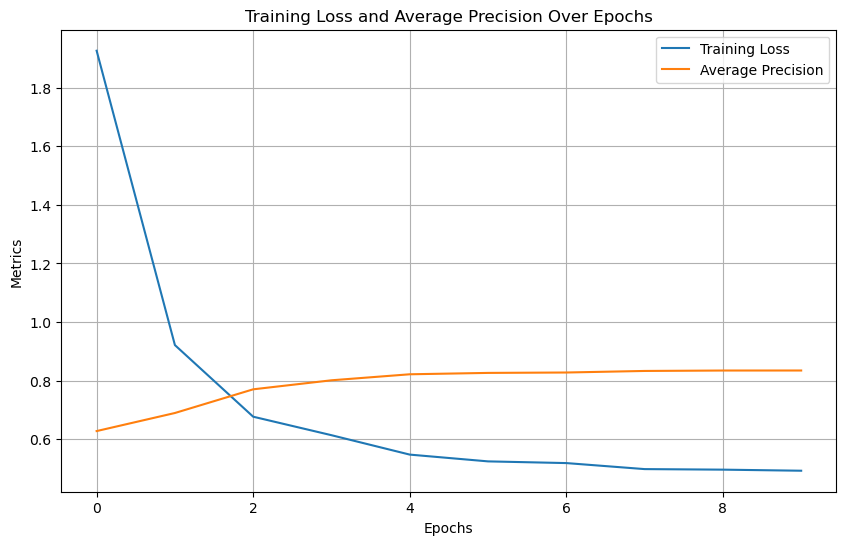

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.plot(epoch_precisions, label='Average Precision')
plt.xlabel('Epochs')

plt.ylabel('Metrics')
plt.title('Training Loss and Average Precision Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

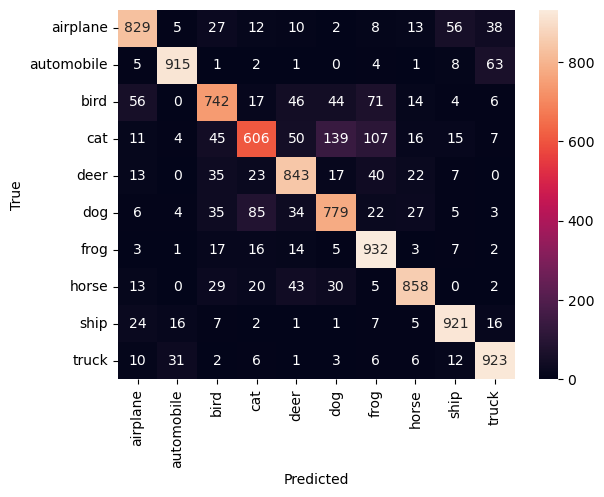

In [17]:
#Mapping to all labels and predictions
all_labels_names = CLPSO_GRAD_script.indices_to_class_names(all_labels, classes)
all_predictions_names = CLPSO_GRAD_script.indices_to_class_names(all_predictions, classes)

# Confusion Matrix with Class Names
conf_matrix = confusion_matrix(all_labels_names, all_predictions_names)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()